# OkCupid Profiles Topic Modeling and Analysis

<img src="images/okcupid_logo.jpg" style="width: 800px;"/>

- This notebook explores OkCupid dating profile bio descriptions.  We have a dataset of profiles containing name, age, location, and description.  The data was obtained using an API.  Here, we use a small sample of ~3400 observations.
- Let's start with exploratory summary stats, then see what clusters and abstract themes form when we apply topic modeling techniques.

In [1]:
# code from: https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

import re
import string
import base64
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF



%matplotlib inline
# from sqlalchemy import create_engine
# import pymysql

In [2]:
# engine = create_engine("mysql+pymysql://[redacted]:[redacted]@[redacted]/[redacted]?host=localhost?port=3306")
# conn = engine.connect()
# sql = 'SELECT * from profile'
# df = pd.read_sql(sql, conn)

df = pd.read_csv('data/OKC_profiles.csv')
df.tail(5)

,id,name,age,location,profile,reverse_cant_tell,rpercentage,orientation,gender,queue,...,tracking_gender,essays,text_queue,pics,epercentage,reverse_score,obUid,fpercentage,matchage,status
7881,8319,7.63955E+17,21,"Valley Stream, New York",1. My self-summary: Okay I suck at biosss but ...,0,0,1,2,queue,...,2,Okay I suck at biosss but here we go. My name...,text_queue,pics,67,0,7.639470e+17,11,21,NaN
7882,8320,mayamayamaya98,20,"Manhattan, New York",1. My self-summary: I don't know....my 5th gra...,0,0,3,2,queue,...,2,I don't know....my 5th grade teacher said I w...,text_queue,pics,30,0,1.819710e+19,61,20,NaN
7883,8321,1.48303E+19,21,"Philadelphia, Pennsylvania",1. My self-summary: Instagram: @daaialza One ...,0,0,1,2,queue,...,2,Instagram: @daaialza One ???????? living in ...,text_queue,pics,48,0,1.483030e+19,28,21,NaN
7884,8322,1.28848E+19,20,"Wenonah, New Jersey","1. My self-summary: Love adventures, a good la...",0,0,1,2,queue,...,2,"Love adventures, a good laugh, and dogs.\n",text_queue,pics,5,0,1.288470e+19,82,20,NaN
7885,8323,7.64408E+18,23,"Ashburn, Virginia",1. My self-summary: Bienvenue ???? I’m advent...,0,0,1,2,queue,...,2,Bienvenue ???? I’m adventurous as hell and I...,text_queue,pics,42,0,7.644070e+18,56,23,NaN


- Opening the csv file in Excel did not decode apostrophes, but when read with pandas, the apostrophes are decoded; however, the encoding for emojis were not saved - "????".

In [3]:
[*df[df['id'] == 2]['essays']]

[' ???? Moved from Washington and kind of new here so looking for people who plan on meeting in person to hang out and I’m not that great at starting conversations in person. ????\n ????Hitting snooze for the alarm and getting 5 extra minutes of sleep.  ???? Cooking  ???? Procrastinating\n ???? Tiny person with tattoos\n']

# EDA

In [4]:
def to_int(x):
    try: return int(x)
    except: return None

df['age'].apply(to_int).describe()

count    7886.000000
mean       22.756657
std         3.000360
min        18.000000
25%        21.000000
50%        22.000000
75%        25.000000
max        31.000000
Name: age, dtype: float64

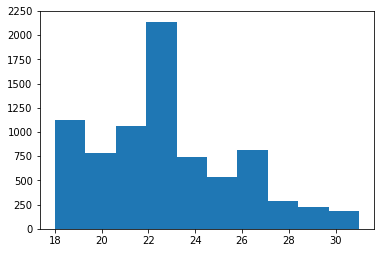

In [5]:
valid_ages = df['age'].apply(to_int).dropna()
plt.hist(valid_ages);

In [6]:
# top_cities = df['location'].value_counts()[:10]
top_cities = [x for x in df['location'].value_counts().keys()[:10]]

top_locations_column = df['location'].apply(lambda x: x if x in top_cities else None)
# top_locations_column[-10:]

top_cities

['Manhattan, New York',
 'Brooklyn, New York',
 'The Bronx, New York',
 'Los Angeles, California',
 'Staten Island, New York',
 'Jersey City, New Jersey',
 'Newark, New Jersey',
 'Jamaica, New York',
 'Astoria, New York',
 'Flushing, New York']

In [7]:
data = [go.Bar(
#             x = top_locations_column.author.map(z).unique(),
            x = top_cities,
            y = top_locations_column.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = top_locations_column.value_counts().values
                        ),
            text='Count of profiles in location'
    )]

layout = go.Layout(
    title='Top locations distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


- Let's see what the most common words are in the uncleaned bio descriptions.

In [8]:
all_words = df['essays'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- There are a lot of junk to remove.

# Tokenize and remove stop words

In [9]:
len(stopwords.words('english'))

179

In [10]:
WORDS_TO_IGNORE = []

stop = set(stopwords.words('english'))
stop_ignore = stop.union(set(WORDS_TO_IGNORE))
# ps = PorterStemmer()

def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop_ignore, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [11]:
# apply the tokenizer into the profile column
df['tokens'] = df['essays'].map(tokenize)
df.reset_index(drop=True, inplace=True)

for profile, tokens in zip(df['essays'].tail(1), df['tokens'].tail(1)):
    print('essay:', profile)
    print('tokens:', tokens)
    print()

essay:  Bienvenue ????  I’m adventurous as hell and I love spontaneous road trips.  Humorous people are my favourite people.  Dad jokes and bad puns are acceptable ????  My music taste is all over the place. It really depends on what I’m in the mood to listen to. Some recommendations would be great as well!  I love learning about cultures and I also love learning new languages. Right now I’m in the process of learning Korean and I’m attempting to reteach myself French ????  I’m currently working on school to become a dermatologist since I’m obsessed with skin care. My friends judge me for having a 12-step daily regimen ????  If this matters I am a ENFP.  Let’s talk ~ ??? ????
 Studying, working, and trying to be a good person

tokens: ['bienvenue', 'adventurous', 'hell', 'love', 'spontaneous', 'road', 'trips', 'humorous', 'people', 'favourite', 'people', 'dad', 'jokes', 'bad', 'puns', 'acceptable', 'music', 'taste', 'place', 'really', 'depends', 'mood', 'listen', 'recommendations', 'wo

# Visualize common words by location
- Let's see if there are patterns in word frequencies by location.  For instance, do women in Beverly Hills use the word 'money' more often?

In [12]:
LA = df[df.location=="Los Angeles, California"]["tokens"].apply(lambda x: ' '.join(x)).values
LB = df[df.location=="Long Beach, California"]["tokens"].values
BH = df[df.location=="Beverly Hills, California"]["tokens"].values

In [13]:
hpl_64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAACXBIWXMAASdHAAEnRwEEDsU+AAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAATbhJREFUeNrsnXeYVdX1ht91aUqxoNgAxYYFKzasaLBij7FFE3vXFEsUY9TEJGo0xsSfvcYWjQ019t41drFGo6BiQwEFlL5+f5w9ZBgZ5s6955x7yvc+zzxYhlO+vc9e3167mbsjhMgvZtYRWBZYEVgMmA/o0eyn5b83/28AE4CJ4c+5/fME4BPgbeA9d58i9YXIcdshAyBEbgJ99xDkVwRWavbnckCnlB9nBjASeCcYgll/uvvnKi0hZACEELUF+x7AZuFnQAj0fXLy+OODIXgReBB4xN3Hq1SFkAEQQnw/4FeAtYCtgC2BQQ3o1SeZLXgeeCAYgmfcfZpKXQgZACHKGvT7hmC/JbA50LMkrz4ReCwYggfc/U3VBiFkAIQoetBfATgQ2I5oDF/AKOBK4Ap3/0hyCCEDIERRgn5n4IfAIcCmUqRVZgL3ApcAd7n7dEkihAyAEHkM/MsBBwP7Ar2kSLv4NGQFLnP3DySHEDIAQmQ96HcCdgQOBX4AmFSpCwceClmB25QVEEIGQIisBf4FgKNDj39RKZII7wEnAf90NVxCyAAI0eDA3wU4PASmnlIkFV4Ghrn7fZJCCBkAIdIO/Ab8GPg90E+KNIRHgRPc/TlJIYQMgBBpBP/NgT8Ba0qNTDAc+LX2ExBCBkCIpAL/6sCZRLv1iWwxA7ga+JW7fyk5hJABECKOwL9Y6PHvBVSkSKb5DDjA3e+WFELIAAhRT/DfCbgUWFhq5IpLgKPdfZKkEEIGQIj2BP7uwLnAAVIjt/wX+Im7PyMphPg+SmcK8f3gvz7wioJ/7lkWeMLM/hA2aBJCKAMgxBwDf0fgZOBEoIMUKRQvA3trpYAQMgBCtAz+/YFrgXWkRmGZDOzr7jdKCiE0BCAEZnZI6CEq+BebeYB/mNkJkkIIZQBEuQN/BfgrcKTUKB2XAYfpcCEhAyBE+YL/PMD1wM5So7TcD+zq7t9ICiEDIEQ5gn9P4A5gQ6lRekYA27r7R5JCyAAIUezg3w+4B1hRaojAp8B27v6SpBBlQpMARZmC/5rAMwr+ogWLA4+b2RaSQsgACFG84L8l8BiwmNQQc6AbMNzMNCwkZACEKFDw/ynwL6CH1BBzoStwV8gUCVH8tlFzAETBg/9ewDWASQ1RJWOATdz9bUkhZACEyGfw3zL0/LUPvGgvo4GN3H2kpBAyAELkK/ivDTwCdJcaokb+C2zs7p9KCiEDIEQ+gv/ywFNAL6kh6uQNYLC7fyUpRNHQJEBRtOC/GHCfgr+IiQHAPWY2r6QQMgBCZDf4z0e0yc/SUkPEyDrABZJByAAIkc3g3xkYDqwhNUQC7GtmB0kGUah2U3MARAGCfwW4AdhVaogEmQJs6O4vSgqhDIAQ2eDXCv4iBboAN4fDpIRQBkCIBvf+NwIeBTpIDZESdxMdHqTGUygDIESDgv+CwPUK/iJlhgInSQahDIAQjTMAtwI7SwnRAGYC27j7/ZJCyAAIkW7wPwwtzRKNZQwwwN3HSAqRRzQEIPIY/FcFzpESosH0As6VDEIZACHSCf5dgeeBlaWGyAhD3f0eySCUARAiWf6q4C8yxkVmpkOnhAyAEAn2/ncDDpQSImMsCfxBMojctakaAhA5Cf4LAO8CC0sNkUFmEu0S+KykEMoACBEvv1XwFxlvSy8LZ1IIIQMgREy9/wHA4VJCZJwBwAmSQeSmbdUQgMiBAXgA2FxKiBwwFVjV3f8jKYQyAELUF/x3VvAXOaIzmhAolAEQou7gPw/wJrC01BA5woF1dGywUAZAiNo5VsFf5NG7An+UDEIZACFq6/33Ad4GukkNkVM2c/dHJYNQBkCI9vEnBX+Rc06XBEIZACHa1/vfEHhSSogCsJO73y4ZhAyAENUZgHuBraSEKABvAKu5+0xJIbKGhgBE1oL/Ggr+okAMAPaSDEIGQIi2OV4SiIJxqpl1kAxCBkCI1nv/ywC7SglRMJYBdpIMQgZAiNY5BlBPSRSRX0oCkblOlyYBioz0/hcBRgLzSg1RUNZ19+clg1AGQIjZ+ZmCv1AWQAhlAES5ev/dgQ+BBaWGKDDTgaXd/WNJIZQBECLiEAV/UQI6AkdJBqEMgBBR778z8D7QW2qIEjAe6OPukySFUAZAlJ1dFPxFiVgA2E8yCBkAIeAnkkCUjJ9JApEFNAQgGlf5oqV/o4nGRoUoExu5+1OSQSgDIMrKHgr+oqTsLQmEMgCizBmAfwPrSAlRQsYCi7v7VEkhlAEQZQv+Kyj4ixLTExgqGYQMgCgjSoEKfQNCNLIjpiEA0aAMwPvA0lJClJgpwGLuPl5SCGUARFmC/4YK/kLQBR1/LWQARMlQ6lMIfQui0Z0xDQGIlHv/nYFPiSZBCVF2nOiAoFGSQigDIIrOlgr+QvzPE6NhACEDIErC1pJAiNnYThKIhrhPDQGIVCuc2dvAClJCiFlMB3ppNYBQBkAUOfj3UfAX4nt0RJkxIQMgCs7mkkCIObKtJBAyAEIGQIjysY2ZdZAMQgZAyAAIUS4WAgZJBiEDIAqHma0KLColhGgVDQMIGQCh3r8QJUTLAYUMgJABEKKErGpmS0oGIQMgCoOZdQIGSwkh2mRLSSBkAESRGAR0kwxCtMlGkkDIAIgi8QNJIIQMgJABEOVjDUkgRFUsa2aLSQYhAyCKwuqSQAhlAYQMgCgRZtYD6CclhKiaDSWBkAEQRWBVojPPhRDKAAgZAFEilP4Xon2sYWZaNSNkAETuWU0SCNEuOqJzAYQMgFAGQIhSomEAIQMg8ouZGbCKlBCi3SgDIGQARK5ZGughGYRoN8qcCRkAoUZMiBKyuJktJBmEDIDIK5oAKIS+HyEDINSACSH0/QgZAFEG+ksCIWpmVUkgZABEXukjCYRQBkBkE3N3qSDir1hmXYFJUkKImvkW6OHuMyWFUAZA5InekkCIuugKLCsZhAyAyBtK/wtRPxoGEDIAQhkAIUrImpJAyAAIGQAhysdukkDIAIi8oSEAIepneTMbLBmEDIBQBkCI8nGAJBAyAEIGQIjysYUkEDIAQgZAiPKxmJktLhmEDIDIPGbWAVhMSggRGwMlgZABELnosQAdJIMQsbG0JBAyACIPLCIJhIiVrpJAyACIPDCvJBBCBkDIAAgZACGEDICQARAyAEIIGQAhAyBkAIQQMgBCBkAUgnkkgRAyAEIGQCgDIISoj+6SQMgACBkAIWQAhJABEJlEQwBCxEsPSSBkAIQyAEIoAyCEDICQARBCBkAIGQAhAyBEEdEQgJABELlAcwCEiNkAmJmWAgoZAKEMgBAlZBlJIGQARNbpJgmEiB0dCSxkAETm0YQlIZQBEDIAQgZACCEDIGQAhAyAEEIGQMgACBkAIURVLCcJRJyYu0sFEW+lMvsamE9KCBErM4EF3H2CpBDKAIgsBv9eCv5CJNZeryUZhAyAyCrLSwIhEmNdSSBkAERW6S8JhJABEDIAQhkAIUR8rCcJhAyAyCrrSwIhEqOPmS0uGYQMgMgUZjY/sJGUECJR9I0JGQCRObYCOkkGIRJlqCQQMgAia2wnCYRInG3MzCSDkAEQmcDMKsA2UkKIxFkU7QcgZABEhhgELCwZhEiFbSWBkAEQWUHpfyHSQ/MARN3oLAART0Uyew1YVUoIkQoOLObuX0gKoQyAaGTwX1vBX4h0PztgN8kgZABEozlFEgiROvtJAlGXi9QQgKiz978W8IKUEKIhrO7ur0kGoQyAUO9fiHKxryQQygCIRvT+BwIvSgkhGsYYoLe7T5MUQhkAkSYnSwIhGkovtCeAkAEQKff+1wR2lBJCNJwDJYGoqR3XEICoIfgb8CiwidQQouE4MMDd35IUQhkAkTQHKPgLkR1PDhwjGYQyACLp3v8iwNvAglJDiMwwBejn7p9JCqEMgEiKcxX8hcgcXYCjJINQBkAk1fvfGrhHSgiRScYBfd19kqQQygCIOIN/V+ACKSFEZlkQrQgQMgAiAU4GlpYMQmSaYWbWQzIIGQARV+9/AHC0lBAi8ywK/EoyiKrads0BEFUYgMfQsj8h8sK3QH93Hy0phDIAop7gv4+CvxC5oivwe8kglAEQ9QT/BYF3iPYbF0Lkh5nAQHd/VVIIZQBELZyh4C9Ebtv2sySDUAZA1NL7Xxv4N9E2o0KIfLKnu98gGYQMgGiPAbgD2F5KCJFrvgRWcvcvJYVoiYYAxJyC/2rAdlJCiNyzMHCeZBAyAKJahqHUvxBFYQ8z21EyiO919jQEIFr0/pcjOu2vg9QQojB8Agxw9/GSQjTRURKIFpyQoeA/Hvgc+IJoLLMHsAjRbmcLy6SIjDAj1M+mujoh1M+murpABp5xCeBsdFaAUAZAtNL77wP8F+jcgNtPB54BHgDuB15296lzedYK0A/YHNgCGIKOKRbpMA54KNTVB4GR7j5zLnW1M7AmsGWoq+s3qPPlwCB3/7eKUMgAiJYN1TnAL1O+7UfAH4Hr3H1CHc9eAQYDvwE2U2mKBHgEOA14bG4Bv4q62gPYCzgR6JvyOzwHrO9q+IUMgGjRMH2YYoM0OgT+y+bW06/xPTYFfgdsrFIVMfAEcLK7PxpzPe1MlJI/Eeid4vvs4+5Xq1iFDIBoaowGAK+ndLsbgf3d/duE3+kw4K9AJ5WwqIFpwM/d/cKE62lX4Apg95Te61Oiw4ImqojLjZYBiia2SeEeM4Fh7r5H0sEfIDTcQ4gmZgnRHr4AhiQd/EM9/dbd9yBafjszhXdbHB0ZLJQBEM16IQ+GYJlkb2pnd7+rAe/Wl2jC1goqaVEF7wBbuPtHDair2wK3kXzW6nOgr7tPU3ErAyDKHfy7k/x4+S8aEfxDD+sjYEfga5W2aIOvgR0bEfxDXb0L+EUKt1oU2EHFLQMgxA9IdunfFe5+QSNf0N3fIZp5PVPFLVphJrBXqCuNrKsXEM0JSJqDVeQyAEJsneC1XwEOz8JLht7V71TcohV+16gs1Rw4PHw7SbKFmfVTscsAiHKT5ATAE9x9Sobe9UyiWdBCNOfTUDcyQfhmTkj4Ngbso6KXARAlJUyQS6oX8LS735el93X3ycDpKnnRgtND3chSXb0PeDrh2wxW0Ze4/dcqgNIbgE2JdjhLgi3c/cEMvnMXoi2Pe6sGCKJNqZbNWKaqqa5uTrSCJSkmAvPXs7OhUAZA5JelE7ruiCwG/9CzmgJcqKIXgQuzGPxDXX0QGJHgLboDA1QFZACEDECc3J3x975HRS9yUheS/pYGqQrIAIhyskxC17034+/9MtERrqLcfBnqQpZJ+luSAZABECWlTwLXnAg8leWXDqehPajiLz0P5uBkvKfCN5UUy6kayACIctIjgWs+k5MtRh9X8ZeezNeB8C09k+AtFlQ1kAEQ5aRbAtfMyzr7T1T8pScvdSDJb0oGQAZAyADExpicvPvnKv7Sk5c6kOQ3JQMgAyBKSncZACEDUGoD0M3MOqsqyAAIZQDKZAC+UPGXnrzUgaS/KWUBZABECdEOYEIIxQIVuighXydwzV45efdFVPylJy91IOlvaoKqggyAkAEokwFYVMVfevJSB5L8phyYpKogAyDKx3gZACEDUGoDMNF1KpwMgFAGICYWz8m7L6HiLz15qQNJflNK/8sACBmA2FjfzDrl4N03UfGXnszXgfAtrS8DIGQARB4MQHdgw4w3qgZsruIvPZuHupBlNiSZ/TpkAGQAhAxAImyd8fdeE1hYxV96Fg51Icsk/S1NVDWQARDl5L2Erjs04++9jYpe5KQuJP0tKQMgAyBKyosJXXdVM8tkit3MugCHqehF4LBQJ7JYVzcHVk34NmNUBWQARDl5DZie0LV/m9F3PhjoraIXgd6hTmSRNL6hN1UFZABECXH374C3Err8Bma2VcZ6VPMAw1TyogXDQt3IUl3dCtgghVu9oeKXARDl5cUEr31GxtKrx5OffQpEeiwe6kZWgn8X4IyUbicDIAMgSsxLCV57DeCCjDSq2wInq7hFK5wc6kgWuCB8O0nzjbt/pKKXARDKACTF/mZ2eIOD/wrAdarzoo328LpQVxpZVw8H9lfvX8gAiDT4NzA24Xuc26jelZn1BW4H5ldRizaYH7g91JlG1NVtgXNTvKUMgAyAKDPuPh24NeHbdALuMLMTUm5QNwZeAFZQSYsqWQF4IdSdNOvqCcAd4VuRARAyACI1/plSfTvdzG4ws64pNKiHAQ+RnzPfRXZYBHgo1KGk62lXM7sBOL0BbfK/VdTlxXQKpAiNUEfgU9LbHnc08EfgMnefGvO7bAr8DthYJSti4AngZHd/NOZ62hk4EDiRxuxL8QWwuLvPVBErAyBKTErDAM3pDZwPvGdmh5pZjzob04qZbWZmDwOPKPiLGNkYeMTMHg51rFJnXe1hZocSbcN9Po3blOpOBX9lAKSCaGqYhgAPNuj204FngAeA+4GX55YZCI1wP6IT/bYAhgALqhRFCowjGlp6IHwvI+cWSENPf01gy1BX1wc6ZuA9tnf3f6k4ZQCEaAqqbwPLZ+SRxgOfE6UqvwR6EI3NLko0VNFBpSYywIxQP5vq6oRQP5vq6gIZfOZJwMLuPlnFJwMgRJMJ2A+4QkoIUWhucfcfSYZyozkAoiXXACMlgxCFZrgkEDIAYjbCZMAzpYQQhWW8DICQARCtcSXRMj0hRPG4wN0nSgYhAyDmlAWYoiyAEIVkMvA3ySBkAMTcuBB4RTIIUSj+7u6fSwYBWgUg5lY5zNYGnkXL7YQoAjOBFdz9PUkhlAEQc8XdXwDOkxJCFIJbFfyFMgCiPVmAbsCbwJJSQ4jcMhlYzd3flRRCGQBRbRZgEnCYlBAi1/xewV8oAyBqzQT8DThKSgiRO14HBrr7NEkhZABELQagM/AksI7UECI3OLChuz8jKURLNAQgqmtFopP5diM6CU0IkQ8uVPAXygCIuDIBOwC3SwkhMs/rwPra9U8oAyDiygTcAfxJSgiRacYBOyn4C2UARNxZgApwE/BDqSFE5pgBDHX3+yWFUAZAxJ0FmAnsTbRLoBAiW5yg4C+UARBJZwJ6BROwjNQQIhP83d33lQxCGQCRdCZgDDAUGCs1hGg4NwIHSAYhAyDSMgHvADsBU6SGEA3jZmBvd58hKYQMgEjTBDwB7Ee06YgQIl2GA3u6+3RJIWQARCNMwD+AX0sJIVLlTmA3BX9RC5oEKOKtUGaXAAdJCSES525g57BLpxAyAKLhBqAjcBewpdQQIjHuA3Z0d829ETIAIlMmYH7gGWAlqSFE7DwIbO/ukyWFqAfNARCx4+5fA9sDX0kNIWLlYWAHBX8hAyCybAL+C+wC6AxyIeLr+W/n7t9JCiEDILJuAh4DDpMSQtTNfURpfwV/IQMgcmMCLgfOkRJC1Mw9RBP+lPYXsaJJgCL5ShadHngHsK3UEKJd3AXsotn+QgZA5NkE9ACeBlaRGkJUxR3ArlrnL5JCQwAiFdx9AtHKgDFSQ4g2GQ78SMFfyACIopiAkcAPATVqQrTOrUTb+2oFjZABEIUyAU8Cw6SEEHPkXmB3BX+RBpoDINKvdGYG3A9sLjWEmMUbwAbu/o2kEDIAosgmYAlgBNBTagjBF8B6YZhMiFTQEIBoCO7+CXCwlBCCKcBOCv5CBkCUyQTcAlwhJUTJOdjdn5EMIm00BCAaWwHN5gPeBRaRGqKE3OTuu0kGoQyAKGMW4BvgJCkhSsin6KwMoQyAKHkWoAK8BKwuNUSJ2Nbd75YMQhkAUeYswEzgF1JClIhLFPyFMgD/6wX2ANYA1gQGAv2A+cPPAkAP4FtgbIuf94FngWfd/XMVaa4zAbcQ7RQoRJH5ElgmbI8t8tdOLQoMCj/LEC1lbv7TFZgAjAe+Dj8jibKcLwOvZKXsG2oAzGxtYBdgB2AlwOq85MhgBu4BbnH3SaquufqwlgHeBjpJDVFghrn7GZIhN+1S9xCntg5Bv1+dl3TgLaLDnm5x9xdKYwDMbHmiiS+7AEsmeKuJwC3AVcBjrskOefnYrgN+LCVEgXv/S7v7REmR6XaoAzAE+Cmwc+jVJ8WHIVZd6O7vFtIAhN7+8UQp3rTnHnwA/AG4yt1nqHpn+sNbjyiLI4R6/yLt9qczcBDReSW9U779TKKDoM5MKyuQuAEwsxWA84ObajT/AU4BblRGINMf4bPAelJCqPcvUuzx/yTEh34ZeKSHgCPc/Z0kb1JJUFAzs6OIJj0MyUg59wf+AbxsZoNU7TPLXyWBKCDnKvhnMvhvBrwOXJmR4E+ImS+b2VHh8LT8ZADMrE8QM8unvc0ATgd+p6M3M/dBdiKa0LmE1BAFwYF+7v6hpMhMO9MNOBM4nPonoCfJg8B+7v5x5jMAZvZjolPesn7UaweiHeieNbOV9TlkqKWMDNkFUkIUiH8r+Gcq+A8GXgOOyHjwJ8TSESG2ZtMAmFlPM7sRuI5o3X5eGAi8YGa76rPIFNdKAlEg/ikJMhP8jwYeJlrDnxcWAK4zsxvNLLYj1GMZAggz/O8AFs9zxxM4yd3/qE8kMx/qq8BqUkLkHKX/s9GedCTKLB6U81f5FNghjpUClRhEHQDcm/PgD1Ea6A9m9vewFEQ0njslgSgASv83PvgvEOLUQQV4ncWBe0PsbZwBMLNlgQeAhQpUV34K/DMsCxGN5Q5JIAqA0v+NDf7dQvAfUqDXWgh4IMTg9A2AmfUmmp24eAHrzI5oEloWeB74TDKInPOYJGhY8O9EtMteEfcVWRx4MMTi9AyAmfUKwb9fgevOwWZ2qj6hxhE2a7pLSogcM51ojblIP/gbcDWwVYFfs18wAb1SMQBmNj9wH7BiCerQKWZ2iD6lhqJhAJFn3nL3KZKhIfwN2KME77kicF+IzckZADPrGnpka5aoEp1vZjvpW2oYT0oCkWNekQQN6f2fDBxZoldeE7grxOjEMgDnAhuWrC51AP5hZhvps0ofdx+L5gGI/PKyJEg9+B8O/LaEr75hiNHxG4Cwc9KBJa1T8wB3mFl/fV4N4Q1JIJQBEFXEqaHAeSWW4MAQq+MzAGY2D3AJ2d8yMUkWBP6u5YENQZOohAyAaCtO9QKuIP3j5jMlA3BJiNlt0rHKi55MdJJe2RkEHAP8SVIoAyBEG3zl7uMkQ2pcCiya8D0c+Ah4G3gHeB/4GpjQ7AdgALA60U6mqwHzp6hD/xCzT2zTLbS1FbCZrQ680A6zUHQmAwPd/S1JkZqz3wB4SkqInPG+uy8rGVJpIw4ALkvo8h8Cw8PPc+7+bQ3PtxZwBukdkjcdWNvdX63ZAIR097PA2g0q10+IThYcAbwV3Fc3oHv4swfRgQ4rhD/TMinPARu6+wx9eql83PMD46WEyBmvuPuakiHx9mEZ4NUQF+LiDeA2YLi7vxjjs25NlEFeNQVpXgAGzS1OtWUAjgb+nHJ5vk10TO8jYQZ4tcJ2ApYF1gd2ArYkmryXFCe4+5n6/FL7yD8GeksJkSMed/fBkiHRdqED8DiwQQyXGwOcA9zi7u8m+MwVYD+ifQq6JizRMe5+TrsNgJktBbyZwgM28TlwKnCZu0+PQeRuwNbBDGxH/EcUTwHW1FBAah/6sxRzO09RXP7l7ttLhkTbhROBP8TQlp8L/NHdv0nx2QcT7avTLcHbfAus7O6j5vQ/5zZb8uiUgv8M4PfAcu5+URzBH8DdJ7n7Le7+E2CRkBG4OBR2HHQhuTEn8X0mSAKRM76RBIkG0N5E2eJ6uAFY0d1PSDP4hxj1GLANMDHB23QNsZyqDYCZ9QD2TSn47+3uv3H3iQkKPc3dH3D3Q4GVgJtiuvQGYd2pkAEQQgYgXX4HzFvj330WWN/d93T3kY16AXd/guisgiTryr4hpledAfgpMF/C7z4d2NPdb0hZ8A/cfTdgY6JJEvXyW32HMgBCyACk2vtfGdinxr/+Z6JJ3M9m4V3c/Wmi4eppCd1ivhDT2zYA4QSlpPdQngbs7u43NVD0J4F1QyUaXcel1jazHfRJqjEVQqY1NU4n2qa9vZ3OQ9z9WHefmaWXcfdniJYJJsWRIba3mQHYgmRP+nNgN3e/NQOiu7tfHd63nlPnTp2TuEKNqSg12jU0md7/RkB7O11fA0Pd/ZIMv9rviZa7J8GKIba3aQCOSvglL3b34RlzXxOBnYGza7zEmkSrDYQMgBBNzCsJEqG9PeWRwAbu/kCWX8rdpxKdt5NUduKouRqAsKFCkpPaPgaOz6j4M939uFAAtYzFnKLvMlE0BCDyRldJEHvvf1XadyLtF8AQd38zD+8X5gOcn9Dlh4YY32oG4AiSPUjhsLSXWtRQAJcTzcps7x7eq5vZuvpElQEQQhmAxNi3Hb87CdjO3d/P2TueSDJHoFdCjP++AQg7Ku2X4Evd4O7/yokLe4RovGRSgpVTtI/pkkAoA1Dq3n9HYO8qf30GsIe7P5+39wxD0knNVdiv+Ym2zXv7A4mOvE2C8cDPclYILwK7tTPw7GFmXfSpJkInSSCUASg12xBt6lYNR+alw9kKlyTU6VkwxPrvGYAk96y+0t3H5NCJ3Q0c3k5xtSRQBkAIGYD42bfK37vO3S/K84u6+2jqW5k2NwanaQAcuCjHBXEp0fKMatlL36kMgBBoCCA2zGwhojNd2uKDdnbasswFqRiAcDrRRgnd7EF3/0/OC+JkoNolJBvrc5UBEEIZgFgZCHRu43dmAHtlfaJ5O3gYeCeB624UYv6sDMDqxH9aXhMX5r0UPDoycV/gqyp+vaeZLa/vVQZAKAMgCWLjpSp+549hR71CEOLOFQlceoEQ82cZgKTS/x+T3DhG2oXxCXBQlb++uL5XGQChDIAkiK39/Qq4fS6/8hrtG6rNC48mdN3BaRiAy919RoEq4W1VOLI3gSf0ycoACGUAJEGsHE60pW9LJgL7hp30isbLwOTEDEDYw36ThB7+oQIWyC+BD+cS/HcIqRsRL50lgShrBsDMuisL4J8AawHXE+3W+gZwLbCJu79c0HeeRjyn1rZkEwsTAVYGeiZwg6QevNEF8g2wP7Ov0ZxAdI7AIHf/r9o9ZQCEIN4hgM3MbCmZAP+vu+8FzOvuq7j7T4oa/JuRxLyGnsDKHYElE3roV9z9u4JWwofCEcBbAK8At7v712rvZvVWOieQjpMBEHmjs5l1iGkY1IGjgZ9LVijS0HIVPJ3QdZesAL1y5FqyVAHvcfej3f1qBf/Zgn8vYIgyAELEmgWYChwQ1sOLcpFULO0lAyDi5kiSOQddBkDkkbgmAk4FutHiMBdRfNz9c+DLvBmAp1V0pev9dw0NVBKzcWUARNkzAABHmZmWF5aPrxK4ZmIGYJy7f6gyKx0HAAvJAAiRSAYAYGGiSciiXIzNkwH4UuVVut5/B6JJSsgACBF7BmBas38+1sy0LFYGILMGYKzKq3TsBvSTARAiEQPQ/JvqBxwiaWUAZABEFnr/BhzfSmMlAyDKTNxDAE382sy6SV4ZABkA0Wh2JxwuIQMgxGzEtclay29qUaJdSYUMQF0GoFtOHlZks/ffETitjcZKBkCUlUUTMgAQzQXoKYlLQRLnAXSrJHRhGYDycCCwnAyAEHNkkQQNwPzAMEmselSrqagASWzXO0nlVYref1fg5CobKxkAoYY7XgMAcKSZ9ZbMhWexBK75XVIZgIVVXqXgZ8DiMgBCNMwAzNOKCRcyAA3LACym8ip8739BZp/5n7QB0LpnkUdimQMQjoVtjf3NrL+klgGoJQMgAyBq4XhggRQNQHdJLkqcAYDZNwNqTkfgPEktA1CLAUhiCGBRlVehe/9LEKX/W+ms+PQEbjuflBclNwAT5vL/tjSzvSR3IdvbTsS3nLQ5GgIQNXEWre9wNiWhe8oAiDzSPcbDe9paXfUXLQssJIsDllQGIAkD0CvsDS+K50a3BH48l1/5OiEHPI/UFzklrozouLbaXeBsyV04Nkzout9VgIkJXLhCMusWRWOD/7zAhXX2UtT7F2Ujrrawmm9rPzPbVJIXii0Suu7ECvBJQhdfV+VWOE4GlpEBEKIhBmBclb93sZl1keyFYfOErvtJBRids4cWjen9rwocG1MvRQZAyAAkkwEA6A/8WrIXot3tD/RN6PKjkzQAW6j4ClMJK8AlRMuNZACEaB9LpJwBADjezFaS9LknyTg6ugJ8nNDFVzCzviq/QnAoMCiBRkoGQJSBpVLOAEC0cdYl4ahukV+SzKR/nGQGIOmHF+n0/pcATk+okZIBEGWgXwMyAAAbAUdJ/ty2vR2AzZLOACRpADQMkH/+1s4ALAMgROMzAE2cbWaDVAS5ZHuiEx+TMwDu/h3JpG0BhigFlWsH+kNglxQaqbaYX6UhcsySMbWDtbTTnYCbzKyXiiF3nJDgtce5+3eVJieQ0E0WATZVOeYy+C8HXJFSL0UZAFFkuhDPZkC1flt9gOvDZF6Rj/Z3U2C9JHv/EG3YA/BhTl2MSKbyzQvcUmPPOwkDsIBKReScfg3KADSxOfA7FYN6/81jfpMBeC3BG21pZgNVnrniImC1BjRSraHDpUTeiWMeQL3f1olmtq2KIvMdsDWBrRK+zWvNDcArCd/seBVrbirfocBP67hEEhkAGQBRegPg7t9S39ktBlxjZkurOErd+58V89MyAD8KY8oi28F/HeDcOi4xExgvA5ALJgC3Ak9IitxkAAA+qvPvLwjcbGY6XCubbfBytH/idd0G4F1gUoI3qwDHqXgzXfEWAm4mmrBUK1+4+8wEHk/HS8fLVcAi7r6Lu28CbANMliyJ0i+m64yK4RoDgfNUJJnkbCDpk3QnhZgfGYDQaI9I+Kb7mNniKt9MBv8KcD2wZJ2XGpnAs82DVgHEyTB338/dZwV8d78X2JMogyOynQEYFdN1DjSz/VQsmWqHDwd2TOFWI5o6as2Xhbyc8E27oFmoWeUUYMsYrjMygWdT+j8+/uXuZ8zpf7j7cOAaSVQaAwBwkZntqKLJRPBfFfhzSrebFeubG4BXUrjxgWFzGZGdijcU+E1Ml0vCACj9Hw/jgIPb+J3fAzMkVSJ0N7OeGTMAnYk2CdpJxdPQNnhe4AYgrXkZrzTKAABcpkOCMlPx1gP+QTQ7OKsGQBmAeDjK3T+d2y+4+3vAdZIqMeKYfT8q5mfqBPzTzHZW8TSMc4GVU7zfHA3ACGBqCjdfELg2HHQgGhf81wfuJ97xdWUAsslwd682sCsLkBwrZfQbazIBu6iIUm+Hd6HtzFycTKXZfL9KM/f/HfBkSg+xCfBrFX/DKt0GwH3EP7luVAKPqwxAfXxFdJxzVbj7u0QTQkX8xNHLGw1MT+DZOgI3mNmPVEyptcP9gMtSvu2TIdZ/LwMAcG+KD3KymW2oapB6pdswlHOPBC4vA5A9jnX3z9v5d5QFyKgBcPcZJHd2S0fgH2a2m4oq8Xa4P/Ao6W9zPluMb6QB6ABcZ2YLqDqkVuk2SjD4f97cWcaIhgBqZyRwbQ1B5j9Ew0MiexmApIx2cxNwvZntruJKrB0eSLQB11INuH3rBsDdRyToLufEUsC9YRMakWyl2xi4B+ieYLBJAmUAaucsd681XfwPyRc7y5hZlxiuMyrh52zqnO2pIou9HR4MPEJ0Um7ajA4xvtUMQNpZAIiOPHzCzPqoeiRa6ZIM/kkaAGUAauNzajvOuYnhaHfAJAJr/xwYgKZnvcbM9lKxxdYO7xjia6M2NvtebM+CAYBoduxTZraCqknslW5T4C6gW8K3GpnAsxugJaO1cW7z3f7ai7tPCPVGxEscwwAfpGhYrjGzP2rVVt1t2T5ER6w38gyGqgzAgzRmAtCSwJNmtraqS2yVbrOUgn9SGYAlqO9sgrLyNXBhDNe5QVJm0gC8mWYzAgwD7jOzXiq+mtrhY4ErSX6P/7kxI8T2uRsAdx8PPNOgh1wYeMTMhqja1F3pDiZK+3dN6ZZvJXBNHVtaGxe6+9cxXOcuolMDRbYMwBuAp/zcQ4AXw+Zhoro2eEUzexg4i/g2W6uVZ0JsbzMDANH4X6PoDtxtZruqCtVU6eYxsyuBi1PuPb8mA5AJJgN/ieNCYVXH7ZI0WwYgDM+MasCz9wUeD4fWiNbb4HnN7PfAq8BmGXmsOcb01gzA1cC0Bj5sZ+BGM7vCzBZWlaq64i1DlL3ZN+Vbf+zu4xK47jIq1XZzhbt/EeP1tBogXpY3s44xXGdEg56/M3C+mT0Uzq4Xs7fB2wCvE2101zkjjzUtxPTqDIC7j8mA8zdgP+AdMzswTAgTrVe8bYEXgDUacPvXErquMgDtYybReeJx8gAwVtLGRidg+RwbgCZ+ALxmZifEZGjy3v72NrObgbsz2HG5PcT0qjMAkP4Wha3RE7iUaILgamo/vlfxFjCzy4B/EZ2z0AhkALLBPe4e6wxxd58G3CZpYyWOMwFGZOA95gVOB14ws3VK2v52NrNfAm8DWT1LodVYXmnD+X+YoZfYgGgSytlm1h1B2Lf7LeCABj+KDEA2uDCh694haWMljomAIzL0PqsDz5rZ5WEYsgxt7ypm9hfgE+Ackt1jpR4+DLG8fQbA3WdS30YiSdAROAZ4s8zHV5rZEmY2HLiJbGyUMyKBd+wM9FasqJpRRKs+kuAB4DtJHBsDYrjGf0jn9NZqqQD7Ew3ZXhX2ui9au9vDzA4ys+dCm/cLIOu72F4RYnm7MwAEAzAzgy/VF7jVzEaY2c/LspWwmXU3s+OI1gHvmJHHmkqU/oqbpaqon+J/XDK3D70ewmqAByRxbKwTQ5lMS+i7i6OTtk/opF1rZivlvbDMbEMzuwL4FLgEWDcnj95mJ77SRiX7iOjY2KyyCnAu8ImZ3WhmW5hZ4YKGmc1vZicRbbbzJ2D+DD3eW3XsNz83lP6vnmnA5QnfQ8sB42NZM+sZw3Vez/A7dgD2Al43s/vNbF8zmy8PhWMRK5jZsWb2FvAk0YT0bjmrZ/eFGF6bAQhcmoMX7QzsRnSC2ftmdrKZLVmAwN/TzH5HlN49jWymm5Ia/9cSwOoZXsORv+3lX2QzG1jaLADZmgcwtxizBdFOeJ+b2U1mtlMY4stKO9vXzH5oZqeb2UPAOKLsylnAijmuY23G7mqWbwwPFW3VnLz0UsBvgVPM7AGiGZB3u/u3eXGfwGDgx8CeZHdySdIGQBmA6rkw6Ru4+xdh7HN9yR0L61J/dvWlnL3zPMCPws94M7sP+DfwPPCSu09KoX1dOJiv5j9FPHF0BFVs6Nexig/fzexk8rcUqAJsFX5mmNmboaI1VbgRYRwtK4F/DaKU2R5Ank5GfEEGoKG84+6PpHSv22UAMpUBeIZoj/c8HtSzALB7+KFFG/0C8FHoiY8Nf45z9ykt2syu4Tpz+pl/Dv+tP9CvJPXrZHdvc7toq+J3msR+AVirQAJNAV4JFa7p552kJlLNQc++oRFYF9iBeNYGp81UYP56Tp0rUX1Lil+6+7kp1dmVSPcgmiLzubsvpu+kXXwXzECnENA7qRrNkRfdvapD9dpjALYmuWVGWWEC8CLREptxwPhmf45v+d/ayiCYWReijYx6Ep12uDb/SzsV4Zz7J9194wQCTSWURVd9y202iL0T2oa5tbJ5F9AWsPGwlLt/WGd5/IVoOZoQTWzj7vdW84tVb+Ho7vea2VPAhgUWrgewafip5uOb1MIYTGsW8HuSv1mj7eXxhK67nIJ/VdyYZvAP3E60F4eon3Wof7O1x2UARDOeqjb4Q/vXWf9G+s5GN6LNalYBNiI6+Wl1on0KupXg/ZMyANryuToubsA9tStgfMSxnvxJyShqjdHtMgBhstHD0lgA04GnZAAaxgh3f7YRPQzgS8mfDQMQDnl5W1IK4OH2TgiuZdOck6SzAF5294kyAA3jkkbc1N1noE2B4mKtmDYue0JSilpic6WGBuCZRjU+IlM8luC1ZQDmznfAtQ28v04HjIcexLPRzOOSUh2CEJuTNQCBY4l2pxPlJZFGx8x6UJ61urVyk7uPb+D9HyRapSHqJ455AMoAlJtRISa3m5oMgLtPIDqC1qV9KZlJcpOPVgVMEs/d7Tfy5mFDlrtUDLEQx8FAo4jOCRHlw4EDQkxOxwCESvcQcJH0LyUvJrj8TOn/ufOmuz+Vgee4VUWRmQwARGc1iPJxUYjFNVHvBJRfAR+oDErH8ASvLQOQ4d5/M+4BJqs46mZ1M4vjvA8tzywfH4QYXDN1GYAwC3x/NBRQNpKcBS4D0DqTgWuy8CDh239ARVI3nYgO/6qXx4BvJGdpcGD/eldiVWJoCB4Fzld5lIb33P2NBK+/qiRulVvcfWyGnkfDAPGweQzt8FTqP11Q5IfzQ+yti0pMD3MC8JbKRL3/ejCzfsB8krhVsrb89g6iDaFEgw1A4E5JWQreCjG3bmIxAOEc522BL1Q2hWd4gtdW+r913nH3TK33DtmIx1Q0dbOKmcVxONjdRMcDi+LyBbBtiLnZMAChMfgA2J5okxJRTMYAT8sANIRLM/pcGgaIhyExtMFfJfx9isbyHbB9iLWxUInz6dz938DeROvERfG4092TLNsNJPEcmQr8PaPPNhxNAs6EAQhoNUAxmQnsHWJsbFTifkp3vxU4TuVVSIYndeGwJ/qGknjOvWx3z+QBPO7+CfCciqhu4poHcKsMWSE5LsTWWKkk1CicA1ygMisUY4B7E7z+6mgCYGtk/ewNDQPUT18z6x9D2/s+OhugaFwQYmrsVBJ86J+h7UKLxNXuPi3B628iiefIe8CjMgDKArSDKyRlYbgrxNJESMwAhGND9wBeUBkWgssTvr4MwJy51N0zndJ19/8Cr6moMmMAbkaHNRWBF4A9QizNlwEIDcNE4AfAIyrLXPO0uye9z8PGkvl7TAOuysmz6ojg+tkszIWpt939FrhBcuaaR4Af1LvTX0MNQKiME4Bt1EDkmsuSvLiZrQj0kszf43Z3z8veGhoGqJ8FgLVjupaGAfLLbcA2tZ7wlykDEEzAFGDXpAOJSIQJwD8TvofS/3Pmkrw8qLu/BvxXRVY3Q2Iqj2fR7qx57WztGmJm4lRSbCBmuPtBwBkq41xxQ1y7TskAtIv3gQdz9szKAtTP5jFeS1mAfHGGux+U5Jh/wwxAMyMwDDgGrVXNCxemcA+N/8+hJ5D1yX8yAImwoZl1jdEATJKkmceBY0JsTJVKQ942WtO4LzpIJOs84O4vJ3kDM1sKWFJSz8Z04MocPvdzwCcqvrroQnSuShzt7FiSX70j6v/W901qnX8mDUConFcDQ4HPVAcySxrDNUr/f5873T1330XIWAxX8dXNrjFe6xx1tDLLZ8DQEAsbQqWRb+/uDxAdAKP9q7PH8+7+sAxAQ7gkx8+uYYD6GRrXMIC7jwJukqSZ4w5gtRADG0al0Sq4+xh33xE4BI1Xla33Dxr/b8ko4P4cP/9jwFgVY110I1o6HRdnSdLMMAk4xN13dPcxjX6YSlZUcfdLgIFo58As8A4ppHLNbFFgBck9G5cnfOJi0t/xdJTRi4NdYyyTl8nfipIi8gIwMMS6TFDJkjru/h9gfeAP6Ejhhvb+UwpC20rq2ZhBMZZuadOv+tnOzOaN8XqnSdKGMTPEtPVDjMsMlawp5e7T3f0kYDAwUnUndZ4jvbPnd5bcs/Evdx9dgPe4H5io4qyLWIcB3P1x4HrJmjojgcHuflLIjmWKSlZVc/cniY6IPRuYonqUWg/0sDTWn5tZd2ALST4b5xXhJdx9MjoJNA52jfl6xwLfSNZUmBJi1+ohlmWSSpYVdPdv3P04onHi69DmQUlzftLr/puxDdGaZxHxhrs/VKD3+buKtG5iHQZw90+BUyVrsmErxKoV3P04d8+04arkQlH3Ue6+N9FBGQ+rjiXCp8BvUryf0v+z87eCvc/9wGgVa110B7aO+ZrnASMkbSI8DKzt7nuH5ZeZp5Indd39JXcfQjR57HXVt1g5Ji23amad0QTA5owFri1UNyjaz/xqFW3d7BpzuUwHjpCssfI6sK27D3H3l/L04JU8qu3udxPNDzgQbT0aBw+5+z9SvN8QYD7JPovLwhnuReNKFW3dbG9m88Tcfj4BXCNp6+aTEINWDzEpd1Tyqry7z3T3y4HlgROAD1Ufa2JqA3oESv//jxnA+UV8MXd/F3hSRVwXSQwDABwHfC15a+LDEHOWd/dc79tRyXtJuPu37n4msDSwPXA32kOgPZzl7u+kdTMzqwA7SvZZDHf3IptXZQHqJ+7VALj756Q75yfvzAyxZXtgaXc/swhZO8vfiaNVBZl+RFsL7w8sorrbKh8AA9z9uxTLZiPgCUk/i01CSraQhOWenxGtaxe1MQFYJCyvjLNsOgAvEg2nijnzBdHmXBe7+8iivVyliCXm7iPD2cp9gT2Bx1WPv8c0YL80g39A6f//8XKRg3/4Fieiw2jqpQfwowTKZgbwE7Rp05x4PMSOvu4+rIjBv7AGoFkFn+ruN7j7YGAA0RKY8arbABzq7o814L4yAP/jbyV5zytU1HVzeEJt5Ajgx2jYlBAbziPKig4OsWNqkV+4kEMAc31hs07ARkTL0LYFVixhRT/L3X/VAO3XAF5GAIwJvYspJfnu3gWWU7HXxcCkNuoys2Mp56mBbxPtWnkX8KS7TyvTy1fKVtruPs3dH3H3Y919pdAo/Zxo45IyNMbDiWawNgL1/v/HxWUJ/oGrVOR1k9hqHXc/m3JM2JwS2vqfA8u5+0ohFjxStuBfygxAGy64G7A5sB0wFFiiYK/4MrCxu09qkL5vACurpjENWCpszVqWb6sPMKqMnY4Y+Q7o7e7jEiqjzkTHBm9cMN0+IZrB/y/gwUa1fzIA+Wu01gS2AtYBBgL9cv4RrNuo0+Y0+382rnf3vUr4Pd0bvidRO8e4+zkJltHCRCeCLpNjjUYCLwHPA/eleL6JDEDBG7CewQg0/1kOsIw/+qfA1u7+WgO1u55oVq2AQe7+XAm/n92AG1X8dfEe0D/JEzvNbHngPqK9VbKMBz1eav7j7mNVTWQA0mrU5gPWbGYI1iI6vTArqc7XgaHu/lEDNVoE+AjorBrDc+4+qKTfSheiTFRPVYO62Mbd7024rBYlSpmvnZF3ngm8Q7RvQVOwfznrp+3JAJSzoesWMgN9wk/fFn/2Abqm8CgPAbu4+9cN1mMY8EfVDAB2c/ebSvxtnAccqWpQF3e6+w4ptWM3ks7BXd8CH4efj1r8+THwnsbuZQCK1BD2nItBWBCYB5i3xU+1PWgH/o9ovHBag9+zArwPLKVS5x1g5TzvHR5DfRhAdBytqTrU1RteNo3NacJugWcCv6T6rOZUogmLzX8mA+NaC/BK28sAiOqCaXNj0NIkNP37x+7+QkaeeTvgTpUeEO28eJXqsd0NbKPqUBdnuvsJKZbZWqGD0hTMWwb3Wf9cZoMrAyDE7A3HXURLKsvOKKJ1x9NVJ2wI0XIzUTtfAn1KtpeEiBmtyRVJNvRLk8xRpnnkTwr+Ee7+EPCqlKiLhYHdJYOQARBZ5RDVMSA6DU/74c/OnyVB3RwhCYQMgMhi778L0XHMAv4c91GuBeAGYLRkqIt1zWwdySBkAETW+BHQSzIwFrhIMsxOWJ1ynpSom1MlgZABEFnjcEkAwF/dXeetz5mL0Vn09TI0bLMthAyAaDxmthqwgZRggnq5c80CjEdzI+JAm2yJZAxA2A1KiPbwM0kAwIVJndxWIM4FZkiGutjYzLSvgmgthvcIe8hUZwDMrGJmx5rZKOBLM9tBMooqK1t/YB8pwXfAOZKhzSzAB8BtUqJu/mBm2l1RtGyPhwFfAN+Y2VNmNni2/99yIyAz60R0CMSWzf7zh0QnUGnTCdFWhbsZ2EVK8H/ufpRkqKrODAKekRJ1s7u7/1MyiPBdbUl0quNsnhs4zt3/3JoBuAA4bA7XO9TdL5asYi4Vbj3gWSnBNKJd/z6UFFXXnafQvJF6+Q/RWRMaUtH31AF4lzkf6TwDGOzuT1Va/KWDWwn+AAdIVtEGZ0oCAK5R8G83Z0uCuukP7CsZBLBjK8EfoANw8mwZgNB7ewLoNJeLrurur0tbMQfHORS4S0owE1jR3d+VFO2qP5XQg11WatTFR8DyGq4t/ff0GLDJXH7FgX7NMwC/byP4g3Z2E6033mdICQD+qeDffsIJcn+REnXTF+3BUfb2eI02gj9Ex3GvWwl/YU1g8yquvXeYJCjEbPUCWFUyMCMYaVEbVxLtnCjqY5iZ9ZAMpaXaZdirNGUAjqvyL/QCtpe+opnb7AKcJiWiAObub0iGmrMA36Klk3HQC/ilZChle9wL+HHVBsDMlgJ2bcc9NBlQNOcIYEnJwCTCxBpRF38BPpEMdXOMmS0kGUrHwUCXKn93QAXYCujYjhtsbWZ9pbMws/mBX0sJIDrx71PJEEsW4FQpUTfzASdJhlK1xxXgoHb8lYUrwJrtvE9FWQAROB7oKRn4DDhLMsTGFcDbkqFufmZm60uG0rA1sFQ7fr9LBVijhhsdEDYaEOV1m0sAv5ASAJyiE/9izQLMAE6QEnVTAa4ys3klRSk4pJ2/37lCbbO3+wA6fKLcnAaoYYE3gcslQ+wm4HbgKSlRN/3RaYFl6JD1BrZt51/rVCHauKQWDpbspa1sQ4D9pAQAv9LWq8lpKwli4edmtolkKDQHEO3w1x6mGNFBP7VM6psBLOXuo6V9qYJ/D2AE7RtrKiqPuPsPJEOi9e02YCcpUTfvA6u5+yRJUbhvpAKMrCGOj6kA42u8bwe0M2AZ+ZOCPxBtpXmsZEicYaGzIepjGXRWR1EZWmMnflIFGFfHjQ8M7kOUw2kOof0TTYrKde7+kmRI2GW5v43mWMTF4WamjFXxqHU4fmI9GQCINoDZTvqXIvj3CA2xSQ0mo/0P0uRU4FvJUP9nDFyhbYIL1S73CxmAWphUrwEA+I2KoRScjVL/TfxNx/2mmgX4FB0UFBdLoaOXi8TxtH/y32wZgK/qfIC1zUxZgGK7zN3Rqo8mvkLLqhrBn4AvJUMsHGxmW0qG3LfLS1DfaqwJFeCtGJ7lFBVHYSvZisBlUmIWv3P3ryVD6lmAb9ChU3FyedjKW+SX46h+3/85MaoCvBrDgygLUMzg3w24GeguNQB4D7hQMjSMi4iWs4n66YOGVfLcNi9C/VnZ/1aA16l9MyBlAYrf4A6QDLM4wd2nSYaGZQGmosmXcbKfme0pGXLJ0UDXOq/xvrk7ZvY2sEIMD7W9u/9LZVMIh3moeruz8Zi7byoZGl4vDXgeWEtqxMJ3wMbu/qKkyM03sCAwCqh3NcdKTWv4X43p2ZQFKEYFGwScKyVmMZn2HbMpkssCOPAzoo2YRP3MCww3s8UkRW74eQzB34EP4jYAmguQ/+DfH7iT+iaXFI1T3P1dyZAZE/A0yk7FSR/gNjPTN5/99rlHMMD1MtrdpzQZgFfibCxVTLmtXIsC9wILS41ZvAj8WTJkjmGAziGJj0HAxZIh8xwBLBjDdd6D6LxogCeAqTFmAXZQOeUu+HcH7gaWlhqzmA4coNP+MpkF+CY0hiI+9jGzoyVDptvouMrnxVkGwN0nAI/F+Kx/NbOuKrLcVKyORMv9BkqN2TjT3V+VDJk1AbcDt0iJWDnLzPaSDJnkt0CvmK71TPMMAECcs/f7oaGAvAR/I9roZyupMRtvoY1n8sBRgDZmio8K8Hcz20VSZKqdXpV4xv5TMQAAR5vZaiq6TFeqCnApsI/UmI2ZwIHuPkVSZD4L8CnwKykRKx2Af5jZUEmRmU7aBUDHmC45yt0/mc0AuPv7xLMtcBMdgUt0XHBmK1VH4FrgAKnxPf4vzDQX+eBSonlMIj46Abfo+OBMsA+wUdy9/5YZgCSyAOsBh6n8Mhf8OwM3AdoF7PuMBE6UDLnKAjjRPg06Mjhe5gHuMLMNJUXD2uqeRAdhxUlqBgCiSSWrqigzU6HmBW4HdpIac+QQd58kGXJnAt4BjpESsdMNuNvMBkuKhnA58U38a+Lp1gzAk0Dc55zPC9wcNjAQjQ3+PYiW+m0tNebIVe5+v2TIrQm4KJhbES/zAfeZ2a6SItX2+sgEOmpfAS/P0QC4+0ySOfq1f3AyonGVqT/wLLCp1JgjnxHfGlvROA4EPpUMsdMFuMHMjpIUqbTXawBnJ3Dpu5rva1JpJeWQxMYnu6ryNKwybQv8G1hZarTKke4+TjLkPgvwJdGkKZ0VED8V4G9mdkaYmS6Saa+7AzeSzHbsd7Qs0JYf0CckMxcA4Oxw0IxIpyKZmZ0UCn1+KdIqt7q7NpQpjgl4ADhHSiTG8UR7BXSSFIlwIVHWPG6mAPfN1QAEktoTujNwp5mpJ5p88O9BtEvaaXMpZwHj0JayReRE4j3jRMzOT4CHzKy3pIi13T4V2Duhyz/k7hOrMQD3EZ03nAQLAw+Y2TIq7sQq0VpEKf+dpUabHO3un0mGwmUBphItc9XSwOTYGHjFzLaRFLG024eT7A6635sgW2nl45lJtLlGUiwh95hIBepsZr8nmuy3ohRpk5vd/SrJUFgT8DbwCymRKAsDd4V5AR0lR81t927AeUl+DkTHvM9+32gPjTk+0KLAB0TL+JLibWATdx+jKlB3BRoIXAVoz4XqeB8Y6O7aR77438alRKsDRLI8Bezh7h9LinbVz82Bu4iGyJPiSXffuKoMQHDPnxPtP5wkKxINByyualBXr/804DkF/6qZCuym4F8ajgzfh0iWDYmGBPaQFFW335sAtyUc/AEumeP9W8sAhIfrFbIA3RJ+uNHATu7+gqpEuyrPEOAvCvzt5mfufp5kKNW30pvoDPRFpUYqPAAc4e7vSopW6+Q+ITAnHfzHAr3dfXLVGYCQBRhDsuMSTfQGHjcz7U1fXcVZzczuAR5U8G83tyr4lw93Hw38CJgmNVJhC2CEmZ1qZl0kx2ztt5nZ6URDtp1TuOXVcwr+bWYAwsP2DFmA+VLS53TgpDARUcxeFn2JlvX9BC3tq4UPiMb9x0uK0n5DRwD/JyVS5b2QDbhf9c+6Ep3CmuYKrZXdfY4n/bYZRNx9LHBuig87DBhuZgvpu5lVaRY0szOA/xDtcqbg336mArsr+Jc+E3A+cKWUSJXliM4SuN3M1i5xO7400bHVaQb/x1sL/lUZgMA5QJoN5/bAO2a2f5m3nDSzVczsIuAjot235lFbUjO/cvfnJYMgOqJcdSF9dgCeN7O7zWyDErXjnczseOB1YGDKt5/rpn5tDgE0e4kTiNLzafMUcJi7jyhJZelAdALUkejgnri4xt1/KhlEs++sD9G56H2kRsN4GDjN3R8tcD3bIAThVRpw+y+AJd19ShwGoDPRMYKN2MZ3OvBX4NSWWxkWqKIsBuwfeidqlOLjaeAHc/sIRGlNwMpEKdmeUqOhPBmC5G3uPqkgdWsB4EzgIKBRWezj3P3sWDIA4aU2Ah5v4AuNJprAc3kRNg8KY0I7Az8E1kdj+3EzCljX3b+QFKKVb3AQ0WqablKj4UwCbgWuBh7O40Tw0JE7mOh8kUUa+ChfAEu7+7exGYDwgpcEV9NIpgI3Axe6+5M5qyADQsD/IbCGvvnEmAhs6O6vSQrRxje5NdGJmTrdLjuMBq4Drs3D8K+ZbRyC/g8zUo/a7P3XagAWBN4iOxtqjCA6PvFad5+QsUrRgWid/nrAIGAjohmxIllmEm0sdaekEFV+q3uGgKNz7rNpBh4JPw+7+8iM1JnuwI9D4F8tQ3pV1fuvyQCEF98D+EfGKsl04CWiMb0niPY+/irFymBEGxqtE4L9esDaKLXYCI539z9JBtHOb/go4G9SIvOMbDIDRKs53nf3aSnUj/mJtjveJPysTTazRlX1/ms2AEGMe4CtM1xJPGQqmgzBB8BX4Wdse8eXzKxCdPJVv/CzdIt/Xgot08sCf3f3fSWDqLFd+x3wGymRK6aH9v0/c/gZ054JwKEjt0Bo6xcC+hJlbjcJvfysz9OquvdfrwFYGngN6J7DCuPAuGaG4CtgMtA19Ni7tfjnbgruueBRYKtwFrwQtbZtFwKHSonCMA2YQDQvaEKLf+4QAn1TwF8w/Le8crS7/6Xqul6rAQgfyo+Jxs2EaDQvEC33myApRJ0GwIhOQpUJEHniTWCN9gyH1JXOcPfrgUulu2gwbwHbKPiLOPCIw4hO2hQiLxzR3rkQdWUAglueh+is7dWkv2gAI4GNwmlvQsSdDfgDcKKUEBnnOnffu931u14DED6SFYhSsN1VDiJFPgM2dvf3JIVI0AT8Gvi9lBAZ5WtgRXf/rL1/MZYZje7+DhovE+kyDthSwV8kjbv/AThaSoiM8ptagn9sGYBmTvlS4ECVh0iYScDm7v6spBApZgIOJZocqM2CRFZ4GVjH3WdkwQDMS7Tmfi2Vi0iIycD27v6gpBANMAH7ApeR76ViohhMBzao55jzWDc1cPfvgG2JNmUQIm4mAFsr+ItG4e5XATsC30gN0WBOqif4x54BaOaS+wNPEW2uIEQcjA3B/3lJITKQCViZ6AChZaWGaAD3h/awrgCeiAEIH8ggor2a51VZiTr5DNjC3V+XFCJDJqAncBPwA6khUuRzYHV3/7zeCyW2r3GYoLUHMEPlJepgFNE6fwV/kSncfSywFdHEQCFSqXbA3nEE/0QNQPhA7iA6KlGIWngnBP//SgqRURMw3d2PAA4jmpQlRJKcEeccqMSGAGa7idlpwEkqO9EOXiFa5z9GUog8YGabAjcTHSojRNw8DQx299iMZipHG7r7b4AzVH6iSh4CNlPwFznLBjwKrAu8KjVEzIwEdokz+KdmAMLHMQztqS3a5q9ER/qOlxQihybgfWA94M9E47VC1MtXRDP+P4v7wqkMAcx2Q7Mjgb+h3bTE7EwBDnP3KyWFKAJmNgT4O9Bbaoga+Y7omPNEdj1N3QCED2Mf4HK0m5aI+BT4obb2FQU0AQsCFwO7Sg3RTmaEdvGOpG5QacRbufvfgd2BqSrj0vM8sLaCvygi7j7O3XcD9iHayVKIajk8yeDfMAMQPoxbiLbU/E7lXFquATZx908khSi4EbgaWJ1oh1Qh2uI0d78k6ZtUGvxR3AtsAnyk8i4VU4BfuPtP3X2y5BAlMQEfAIOB36Dsp2idP7j7yWncqCFzAL73EGa9gH8Cm6rsC8+rwE/cfYSkEGXFzJYDziU6PE0IiFaNHO3u56Z1w0om3jpa770F8BfVgcIyEzgTWFfBXygb4O+5+3bAdsB7UqT0TAf2TTP4ZyYD0MIZ/xi4FOiqOlEYPgB+6u5PSgohvtfmdQaOJtottZsUKR2Tgd3c/c7U617WDED4IFYHbgOWVt3IPZcDv3R3zYAWYu7tXm/gLGBPqVEavgZ2cPfHG1LnsmgAwsfQk2gTje1UR3LJF8BBSS9jEaKARmBj4DyiVQOiuHwUgv8rjXqASlaVcfex7r498BNgrOpKbphBdDzqygr+QtTU9j0BrAUcgOYHFJU7gDUaGfwznQFo4YgXBc4HdlG9yTQPEy3v0yQ/IeJp+zoAuwG/BgZIkdwzFTg+7cl+uTYAzT6GHwH/ByyqepQp3geOdffbJIUQibR9BuwUjMBaUiS37eTu7v5CVh6okif13P1mYGXgWtWlTDARGEaU7lfwFyK5ts/d/TZ3XxvYBu0omDduAtbMUvDPXQaghSPeFjgH6K+6lX57BFwNDHP3TyWHEA1pAwcTLR3cXGpklnFEKf9LM1mH8moAwgfQAdgPOAXoo7qWOFOB64Cz3P0tySFEJtrB1YkmDO4F9JQimWAm0RLoE939y8zWnTwbgGYfwDzAEUTp6IVU92LnG6IjTc/VwT1CZLYd7EJ0wNr+RDurVqRKQ3gGOMrdX8x8nSmCAWj2AcwHHAv8Euiuelg3nwJ/BS5y968lhxC5aQv7APuGn2WlSGrt5fHAtZ6TwFooA9Cs8i8CnAgchLYUroW3gbOBa9xdp5YJkd+20IhOINyfaBm12sP4+Y5oddppedvxtJAGoFnlnx/YGzgEWFX1dK58A9xKNMb/kBe5YghRTjMwH9HOqkOBrYCFpUpdjCba9Oxid/8ql3WiLO28ma0fjMBuwLyquwBMAe4OQf8ud58sSYQoRXtYAdYJZmAo0d4CJmWq4t9ERznf7O7Tcl0PytbRM7MFiLYXPoRy7qw1E3gUuB64xd3H63sWovSGYBFg62AGtgQWlCqzMR24Bfiruz9TmHIvc6bXzNYDtifaWGPNAjvg8cCTwIPATZrJL4SYS7vYARgUDMG6wEDKOVwwHXiCaN/+m93948KVtYZ6Z1X6xYIRGEq0hGb+HL/OV6HiPhZ+XnX3mSplIUSN7eOSRMMEA8OfawGLFPBVvwHuCUH/7qJnSGUA5lzZOwIb8L902ACgc4Yf+bPQw28K+K9rEp8QIuF2snczM9BkDBbP2WvMBN4F7g9B/7G8j+vLACRjCJYHVmnxsxzpbbbxdaio7wL/afbP77r7OJWSECIDbWU3oG+znyVb/HtfoFuDHu8r4LXwMyL8+Ya7f1va8pIBqKuyz0N0ONEAoDfRsMH8wHyt/HMPYBrRIToTgQnN/rnlv08APm4W5MdIcSFEAdrNni3MwUJEK7O6Nvup5t+nh47R10Sp+6/n8DOOaF+TEZr79H3+fwCzX593XFX7KgAAAABJRU5ErkJggg=='

In [14]:
import codecs
# Generate the Mask for LA
f1 = open("data/octopus.png", "wb")
f1.write(codecs.decode(hpl_64,'base64'))
f1.close()
img1 = imread("data/octopus.png")
# img = img.resize((980,1080))
hcmask = img1

# f2 = open("mws.png", "wb")
# f2.write(codecs.decode(mws_64,'base64'))
# f2.close()
# img2 = imread("mws.png")
# hcmask2 = img2

# f3 = open("hpl.png", "wb")
# f3.write(codecs.decode(hpl_64,'base64'))
# f3.close()
# img3 = imread("hpl.png")
# hcmask3 = img3;

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

`imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.



(-0.5, 511.5, 511.5, -0.5)

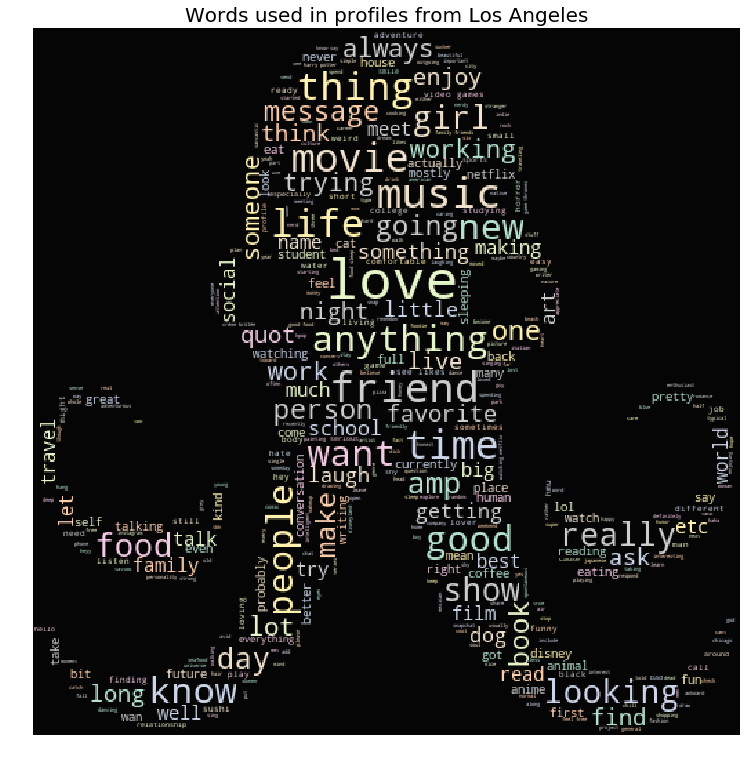

In [15]:
# The wordcloud of octopus for Los Angeles, CA
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(LA))
plt.title("Words used in profiles from Los Angeles", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [16]:
stemmer = nltk.stem.PorterStemmer()

print("The stemmed form of really is: {}".format(stemmer.stem("really")))

The stemmed form of really is: realli


- Since we'd like to preserve the original words, stemming is not desirable because some words are crudely collapsed and not recognizable.
- For instance:  The stemmed form of really is: realli.
- Instead, let's use lemmatization.

In [17]:
# nltk.download('wordnet')

In [18]:
lemm = WordNetLemmatizer()
print("The lemmatized form of looking is: {}".format(lemm.lemmatize("looking")))

The lemmatized form of looking is: looking


# Count Vectorizer

In [19]:
vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 1))
essay_transform = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))
# print("The features are:\n {}".format(vectorizer.get_feature_names()))
# print("\nThe vectorized array looks like:\n {}".format(essay_transform.toarray()))

In [20]:
"The size of the vocabulary is {}".format(len(vectorizer.get_feature_names()))

'The size of the vocabulary is 7885'

In [21]:
feature_names = vectorizer.get_feature_names()
count_vec = np.asarray(essay_transform.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# TF-IDF
- Let's see which words have the lowest/highest tf-idf values.

tf-idf is the acronym for Term Frequency–inverse Document Frequency. It quantifies the importance of a particular word relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors:

    Term Frequency: the occurences of a word in a given document (i.e. bag of words)
    Inverse Document Frequency: the reciprocal number of times a word occurs in a corpus of documents

Think about of it this way: If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. So the second term could be seen as a penalty term that penalizes common words such as "a", "the", "and", etc. tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.


In [22]:
tfidf_vectorizer = TfidfVectorizer(min_df=1,
                             max_features=None,
                             tokenizer=tokenize,
                             ngram_range=(2, 3)
                            )

all_essay = df['essays'].values
vz = tfidf_vectorizer.fit_transform(list(all_essay))

vz is a tfidf matrix where:

    the number of rows is the total number of summaries
    the number of columns is the total number of unique tokens across the summaries

In [23]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))

tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Below are the n tokens with the lowest tfidf score, generic words that we could not use to distinguish one summary from another.

- Let's see the bigrams with the lowest tf-idf scores.

In [24]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
harry potter,3.805455
family friends,3.886196
see likes,4.030172
get know,4.043382
game thrones,4.089649
video games,4.138160
new things,4.289391
full time,4.296217
new people,4.306544
watching netflix,4.320482


Below are the n tokens with the highest tfidf score(tokens with the same low frequency count all have the same tf-idf score), which includes words that are specific.

In [25]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(5)

,tfidf
aaa akmu,9.279824
paper cut time,9.279824
paper crane,9.279824
paper crane anything,9.279824
paper cranes,9.279824


- We want to change the tf-idf vectorizer back to unigrams when we do topic modeling.  The set of all bigrams and trigrams would take longer to compute.

# Topic Modeling

    Latent Dirichlet Allocation - Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.
    
    Non-negative Matrix Factorization - Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.
    
- study how LDA and NMF work in kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

In [26]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

### LDA on CountVectorizer

In [37]:
lda = LatentDirichletAllocation(n_components=20, 
                                max_iter=5,
                                learning_method = 'online',
#                                 learning_offset = 50.,
                                random_state = 0)
lda.fit(essay_transform);

n_top_words = 30
print("Topics in LDA on CountVectorizer model: ")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topics in LDA on CountVectorizer model: 
Topic #0:amp food shows music books game friends coffee thrones watching netflix anything movies book favorite body school good family tea dogs reading pizza show office eating night dog sleeping trying
Topic #1:adult shit hit hip hop salsa delicious edm gender lived app female trap crying lmao dogs fam ride kpop production suck pet click office annoying lowkey drunk interest visual using
Topic #2:rican bisexual wwe expand dancehall bdsm session paintings welcomed ignored lily liquor oatmeal pal environments horizons purely comprehensive vibing jose wassup tropical crossed bilingual heyyy eager bellion outer chubby discuss
Topic #3:energy shot buying bottle waiting real hippie preparing shoot maintenance selling table shots split reaching boss virgo rats subway yelling sensitive npr wholesome brings responses feminine exists privilege recipe pokémon
Topic #4:term google tennis names team riding soon junior graduating meditation setting crystals 

- Topics in LDA on CountVectorizer model:
> - We can someonewhat get a sense of the types of profiles that would belong to each of these topcis.
  - For instance, "Topic #13:hmu brazilian weed english smoke student goofy nyu extra chill blah guilty pleasure friendships experiencing colombian snap loves lil financial hugs lookin improve washington coach dreadful grab hang margaret travels" is the stoner group.
  - "Topic #17:see likes message instagram com cant https snapchat trans fashion queens www body talk text countries lover bios moonlight lets queer race free silly dancer lived sewing gender purity btw" is the transgender group.
  - "Topic #10:music movies books black shows anything favorite etc series harry rock potter american one things star horror art fiction house wars also dead club bad office food show writing orange" are the TV/film afficionados.

In [43]:
X_topics = lda.fit_transform(essay_transform)

unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, essay in enumerate(df['essays']):
    lda_keys += [doc_topic[i].argmax()]
    
df['lda_cvectorizer_topic'] = lda_keys

df['lda_cvectorizer_topic'].value_counts()

5     5045
14     748
0      745
10     575
6      469
17      90
12      52
13      36
18      32
9       17
1       17
16      15
11      10
7        7
19       7
4        6
2        5
15       5
3        4
8        1
Name: lda_cvectorizer_topic, dtype: int64

- Let's see the profile bio for the person who's in topic 8:
        "Topic #8:eric chipotle legs capitalism fly obvious andre boxing bringing metamorphosis bout scissorhands fuckin cheerful jordan plath sylvia monogamous houston boogie genesis vince bff lou janet auditioning taboo grips splatoon evangelion"

In [52]:
for x in df[df['lda_cvectorizer_topic'] == 8]['essays']:
    print(x)

 ‘Sup, fuckers?



- So, even though the only tokens in topic 8 are 'sup' and 'fuckers', the LDA topic modeling technique looked for latent words to describe the profiles in this group.

In [51]:
for x in df[df['lda_cvectorizer_topic'] == 3]['essays']:
    print(x)

 Shoot your shot ????

 Real.

 Optimist and Funny :)))

 20, Virgo. Simple



Topic #3:energy shot buying bottle waiting real hippie preparing shoot maintenance selling table shots split reaching boss virgo rats subway yelling sensitive npr wholesome brings responses feminine exists privilege recipe pokémon

- As a sanity check, we're satisfied that tokens used in profiles that belong to topic 3 at least show up in the topic descriptor list: "shot", "virgo".

### LDA on tf-idf

In [55]:
lda_model = LatentDirichletAllocation(n_components=20,
                                      learning_method='online',
                                      max_iter=5,
                                      random_state=0)

# unigrams
tfidf_vectorizer = TfidfVectorizer(min_df=2,
                             max_features=None,
                             tokenizer=tokenize
#                              ngram_range=(2, 3)
                            )

vz = tfidf_vectorizer.fit_transform(df['essays'])

X_topics = lda_model.fit_transform(vz)

n_top_words = 15
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = tfidf_vectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))
    print("======================================================================")

Topic 0: dermatologist | unattractive | smokers | downs | gymnast | valerie | confident | earth | stylish | joined | lung | ups | say | hey | afraid
Topic 1: virginia | junot | diaz | woolf | argentina | barnard | getter | shepard | carol | nicolette | watercolor | arie | rifle | dent | cheek
Topic 2: indonesia | indonesian | steal | powder | infp | psa | location | cat | obsessed | live | turn | soul | adventure | horror | old
Topic 3: ads | wassup | domestic | goddess | assertive | eggers | pictionary | bumble | realtor | elegant | dfw | oblivion | goodwill | hyphens | perfer
Topic 4: brazilian | gin | xiu | arrive | thee | mtl | alps | nun | hamtaro | bolaño | ham | encounters | curls | downing | emails
Topic 5: adventuress | loveee | squat | hiiiii | meetups | tees | deadlift | alyssa | flow | energetic | ucla | going | dancer | serious | nothing
Topic 6: loaf | cabinets | comprehensive | trans | later | love | meeting | new | spent | cats | cant | model | message | finish | animal

- LDA on TF-idf
> - There are some distinct groupings; however, it's more difficitult to tell the personalities of some of the groups.  Since it uses tf-idf, the words are more specific.
  - Topic 5 is the active/exercise group: "Topic 5: adventuress | loveee | squat | hiiiii | meetups | tees | deadlift | alyssa | flow | energetic | ucla | going | dancer | serious | nothing"
  - Seems that people at UCLA tend to talk about fitness.
  - Many topics seems meaningless.
  - These would be helpful if you had a fetish group -- for instance, girls that like ASMR (Topic 16: hello | models | enders | addictive | conspiracies | context | bending | tools | asmr | moroccan | luxury | aux | emerson | layer | conveys).

In [57]:
# X_topics = lda_model.fit_transform(vz)


unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, essay in enumerate(df['essays']):
    lda_keys += [doc_topic[i].argmax()]
    
df['lda_tfidf_topic'] = lda_keys
df['lda_tfidf_topic'].value_counts()

8     7437
0      407
16      14
18       7
4        6
13       5
11       4
1        2
3        1
9        1
5        1
12       1
Name: lda_tfidf_topic, dtype: int64

- It makes sense that almost all the profiles fall into topic 8: "Topic 8: love | like | friends | music | new | food | good | time | looking | people | life | movies | amp | fun | know"
- However, it's not ideal that the profiles are not as well distributed.
- It would be cool to filter out these words and then see where everyone ends up after that.

In [68]:
for x in df[df['lda_tfidf_topic'] == 3]['essays']:
    print(x)

 Wassup



In [69]:
for x in df[df['lda_tfidf_topic'] == 18]['essays']:
    print(x)

 Instagram: siyowin

 Instagram: @miicarvalh0o

 I'm a photographer! Catch me in the CVS seasonal aisle hoarding clearance items. Currently a senior at NYU. @mia.sophia is my Instagram.

 Instagram: Queenjaystyles

 Instagram: @amandacherre

 Hit me up and find out. ??????????? Instagram: juju_beann_

 Instagram: cxirena



    Topic 18: instagram | sunscreen | nonchalant | juju | mma | seasonal | cvs | umbrella | comix | meee | sorting | selective | sophia | tyb | ángeles

- Unfortunately, topic 3, the one that includes the word "ucla" in the topic list, had only 1 profile belonging to it, yet the token "ucla" did not show up in the document.
- However we can see that the algorithm is somewhat working for topic 18, because "instagram" does show up in both the documents and the topic descriptor.

# NMF on CountVectorizer

In [94]:
model = NMF(init="nndsvd",
            n_components=20,
            max_iter=200, random_state=0)

# a = vectorizer.fit_transform(summary_df.summary)
a = essay_transform
W = model.fit_transform(a)
H = model.components_

terms = [""] * len(vectorizer.vocabulary_)
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:30]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))
    print("======================================================================")

Topic 0: like, think, would, read, lot, stuff, watch, sometimes, feel, probably, make, different, look, going, want, old, something, never, real, etc, haha, movies, need, guess, still, thing, movie, thinking, usually, makes
Topic 1: quot, big, probably, old, year, still, right, please, pretty, one, body, makes, read, see, always, history, black, online, would, sometimes, fuck, true, never, long, world, etc, way, books, first, little
Topic 2: movies, books, shows, anything, harry, potter, horror, watching, black, series, etc, dead, american, game, one, thrones, disney, parks, star, office, rock, big, walking, marvel, bad, rec, watch, story, burgers, girl
Topic 3: love, movies, well, laugh, going, animals, girl, anything, would, huge, watch, travel, sports, fan, movie, romantic, especially, want, cook, haha, make, name, someone, horror, cooking, comedy, outdoors, try, great, always
Topic 4: amp, nbsp, family, anything, black, hop, hip, girl, away, everything, making, book, world, horror,

- NMF on CountVectorizer
> - Usually, this method gives the most common words, and it seems to be the case here with this dataset.
  - "Topic 9: food, eat, netflix, shows, school, eating, anything, cooking, mexican, trying, italian, home, watching, work, bed, sleep, thai, book, phone, sushi, pizza, future, books, korean, chinese, lol, water, spicy, watch, reading"  are the foodies group.
  - "Topic 16: looking, someone, message, see, likes, fun, lol, please, girl, relationship, person, something, find, talk, serious, first, interested, meet, would, shy, sex, guys, name, ask, send, guy, dont, need, hook, let" wants a serious relationship moreso that a hookup.
  - "Topic 18: games, video, playing, anime, play, game, series, watching, lot, enjoy, manga, star, animals, reading, super, horror, drawing, internet, shy, wars, netflix, fantasy, dead, nerd, one, mario, many, dragon, hunger, watch" contains the nerds who like anime and star wars.
  - This set of topics seems straightforward.  It doesn't look for latent or highly weighted words, which might be the best way to go, depending on your application.

In [95]:
unnormalized = np.matrix(W)
doc_topic = unnormalized/unnormalized.sum(axis=1)

nmf_keys = []
for i, essay in enumerate(df['essays']):
    nmf_keys += [doc_topic[i].argmax()]

# lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
# df['summary'] = sample['summary']
# df['genre'] = sample['genre']
df['nmf_cvectorizer_topic'] = nmf_keys
# df['nmf_tfidf_topic'] = lda_df['nmf_topic'].map(int)

df['nmf_cvectorizer_topic'].value_counts()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



3     926
0     785
16    779
6     750
8     531
5     475
2     473
4     425
7     355
13    309
18    284
19    274
9     248
15    241
1     213
17    200
10    171
12    162
11    150
14    135
Name: nmf_cvectorizer_topic, dtype: int64

        Topic 14: also, lot, art, work, enjoy, currently, make, big, one, book, school, reading, fan, though, recently, kind, pretty, writing, probably, still, working, many, draw, back, get, disney, mind, watch, parks, films
        
        Topic 10: music, listen, shows, pop, listening, working, art, rock, coffee, lol, country, writing, hop, dance, punk, metal, anything, etc, hip, hair, going, rap, classical, american, name, singing, alternative, jazz, future, indie

In [96]:
for x in df[df['nmf_cvectorizer_topic'] == 10]['essays'][50:55]:
    print(x, "==========================================================================================")

 Music and nature ?????
 Unnecessarily smiley and notoriously indecisive. I pet too many dogs, drink too much coffee and read too much news. Passionate about journalism, communications, and politics. Just tryna make the world better ????  I love distance running (esp finding the scenic places to jog in NYC), hiking, and any outdoorsy adventure
 What I tell people: Studying Political Science, Public Policy, and Media at Hunter College. Doing digital work for a progressive agency this summer!  In reality: figuring out how to adult, pretending I know what I’m doing, lowkey wanting to escape into the middle of the woods cause there’s too much going on right now ????
 Writing, running, listening and giving advice. Waking up after 12 alarms. Spacing out when I shouldn’t. Procrastinating but miraculously pulling through. Saying I’ll save money, and then immediately purchasing overpriced coffee.
 I tend to be pretty overenthused at first, though apparently I’m also “peaceful” ????
 Shows: The 

- I'm happy that these are consistent.  For example, essays in topic 10 tend to be about music.

# NMF on Tf-Idf

In [97]:
# a = tfidf_vectorizer.fit_transform(summary_df.summary)

a = vz  #vz = tfidf_vectorizer.fit_transform(list(all_essay))
W = model.fit_transform(a)
H = model.components_

terms = [""] * len(tfidf_vectorizer.vocabulary_)
for term in tfidf_vectorizer.vocabulary_.keys():
    terms[tfidf_vectorizer.vocabulary_[term]] = term

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:30]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))
    print("======================================================================")

Topic 0: music, movies, favorite, food, books, shows, anything, horror, harry, potter, game, book, rock, black, things, series, movie, games, show, also, much, one, thrones, office, etc, many, pop, american, pretty, reading
Topic 1: message, see, likes, cant, send, please, interested, talk, find, dont, free, add, hookups, hey, app, feel, liked, chat, goofy, chill, instagram, also, text, hmu, shoot, first, btw, shy, paying, let
Topic 2: love, laugh, food, music, also, traveling, animals, travel, adventures, dogs, dancing, sports, dance, people, going, movies, dog, talk, nature, cook, outdoors, meeting, someone, art, well, huge, hiking, enjoy, really, cats
Topic 3: fun, loving, energetic, crazy, around, goofy, adventurous, loves, girl, silly, always, party, adventures, laughing, medicine, yet, summer, strong, sweet, pretty, fit, need, hey, adventure, ready, enjoys, nice, loyal, personality, laid
Topic 4: new, people, meet, things, york, trying, places, meeting, try, city, exploring, lear

- NMF on TF-idf
> - In my experience, these results are typically more impressive in drawing out more interesting words while still making sense.
  - Here are the gamers:  "Topic 17: games, video, playing, anime, play, also, loves, shy, watch, animals, game, enjoy, watching, overwatch, movies, nerdy, nerd, drawing, series, first, cats, reading, memes, horror, manga, sports, comics, dork, art, gamer".
  - "Topic 10: new, people, meet, things, york, places, trying, meeting, try, city, exploring, traveling, moved, make, learning, always, friends, explore, hey, adventure, open, enjoy, nyc, loves, jersey, student, travel, making, foods, learn" are new to New York city.
  - From these topics, we can get a good sense of the personalities of these people.

In [98]:
unnormalized = np.matrix(W)
doc_topic = unnormalized/unnormalized.sum(axis=1)

nmf_keys = []
for i, essay in enumerate(df['essays']):
    nmf_keys += [doc_topic[i].argmax()]

# lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
# df['summary'] = sample['summary']
# df['genre'] = sample['genre']
df['nmf_tfidf_topic'] = nmf_keys
# df['nmf_tfidf_topic'] = lda_df['nmf_topic'].map(int)

df['nmf_tfidf_topic'].value_counts()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



0     1357
17     774
13     643
9      480
12     458
11     447
10     431
2      423
4      406
19     356
8      302
16     266
1      262
6      259
7      236
14     223
15     195
3      152
5      136
18      80
Name: nmf_tfidf_topic, dtype: int64

    Topic 18: hello, name, everyone, let, instagram, brazil, sylvia, app, kitty, single, english, years, live, say, old, using, enthusiast, dana, started, approaching, show, smoke, nervous, catch, guys, hispanic, short, scared, philippines, soon

In [99]:
for x in df[df['nmf_tfidf_topic'] == 18]['essays'][:5]:
    print(x, "==========================================================================================")

 Hello! First and foremost, I would like to make it clear that if your intentions are to hook up or have a FWB, I am not your gal. My name is Nancy, I am a 24 year old college student majoring in Fashion Merchandising. I do not have any children, I do however, have two beautiful dogs who are my world. Music is a big part of my life and I listen to almost any genre; I’m always going to concerts, maybe we can go to one? (: Don’t go to clubs and rarely go to parties, I would rather go to a nice bar and hang out. I am always at the gym, it is like my second home, weight training is a new found hobby of mine. I am currently just looking for someone I can talk to, hang out with, and if something blossoms from there, then I wouldn’t be opposed to it. Humor is a big plus for me, so if you’re funny, you’re already a step ahead of everyone else. Lol
 Hello????  Hit me up I'm super chill. I'm down to grab some food and chill at a park at talk about aliens and weird shit. i love to smoke weed so h

- We analyzed topic 18 and the labeling makes sense, but the descriptor is not too great.  Let's see one that might be more obvious.

    Topic 4: new, people, meet, things, york, trying, places, meeting, try, city, exploring, learning, make, traveling, moved, brazilian, always, explore, loves, hey, nyc, open, adventure, jersey, travel, enjoy, friends, making, foods, learn

In [103]:
for x in df[df['nmf_tfidf_topic'] == 4]['essays'][:5]:
    print(x, "==========================================================================================")

 Just looking to meet new people. Message me!
 I got my bachelor degree and I'm ready for the next adventure!
 21. Slytherin. Current Latina student at CSULB. Total foodie and loves to try anything new. I love anime and my favorite band are the Beatles. Follow me on IG @stphmeister
 Hi Im Kimi (: located out here in ktown La ^^ Looking for new friends to explore with -shopping,golf,tennis,gym -food so lets eat^^ -cars -music -sailing -personal development -i work with a company that is partnered and hosts shows for H1ghrmusic and Aomg. As well as other small jobs /accounts  Its easier to reach me through Instagram Snapchat or KakaoTalk.- @kimighosttaco Instagram @__babybambi__ Wechat @kimisomelove1  Seattle New York San Fransisco Los Ángeles  I enjoy traveling and meeting new people. You never know what you might learn .
 -loved ones -water -umbrella -sunscreen -coffee -soap
 Food
 Heyy Im New :)
 Heyy Im New :)


- These profiles makes sense because the word "new" appears in them.  It's not necessary "new york".  If we wanted to be more sensitive to the difference, we could tokenize with bigrams instead of only unigrams.

### NMF on CountVectorizer is the favorite.
- The topics are most straightforward, as expected.  It's also the most somewhat uniformly distributed.

### Visualize the clusters

In [105]:
model = NMF(init="nndsvd",
            n_components=20,
            max_iter=200, random_state=0)

# a = vectorizer.fit_transform(summary_df.summary)
a = essay_transform
W = model.fit_transform(a)
H = model.components_

terms = [""] * len(vectorizer.vocabulary_)
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:30]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))
    print("======================================================================")

Topic 0: like, think, would, read, lot, stuff, watch, sometimes, feel, probably, make, different, look, going, want, old, something, never, real, etc, haha, movies, need, guess, still, thing, movie, thinking, usually, makes
Topic 1: quot, big, probably, old, year, still, right, please, pretty, one, body, makes, read, see, always, history, black, online, would, sometimes, fuck, true, never, long, world, etc, way, books, first, little
Topic 2: movies, books, shows, anything, harry, potter, horror, watching, black, series, etc, dead, american, game, one, thrones, disney, parks, star, office, rock, big, walking, marvel, bad, rec, watch, story, burgers, girl
Topic 3: love, movies, well, laugh, going, animals, girl, anything, would, huge, watch, travel, sports, fan, movie, romantic, especially, want, cook, haha, make, name, someone, horror, cooking, comedy, outdoors, try, great, always
Topic 4: amp, nbsp, family, anything, black, hop, hip, girl, away, everything, making, book, world, horror,

In [106]:
unnormalized = np.matrix(W)
doc_topic = unnormalized/unnormalized.sum(axis=1)

nmf_keys = []
for i, essay in enumerate(df['essays']):
    nmf_keys += [doc_topic[i].argmax()]

# lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
# df['summary'] = sample['summary']
# df['genre'] = sample['genre']
df['nmf_cvectorizer_topic'] = nmf_keys
# df['nmf_tfidf_topic'] = lda_df['nmf_topic'].map(int)

df['nmf_cvectorizer_topic'].value_counts()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



3     926
0     785
16    779
6     750
8     531
5     475
2     473
4     425
7     355
13    309
18    284
19    274
9     248
15    241
1     213
17    200
10    171
12    162
11    150
14    135
Name: nmf_cvectorizer_topic, dtype: int64

# reduce dimension to 2 using tsne
- first do SVD to go from p dimensions to 30, then apply tsne to go from 30 to 2.  Tsne is ideal for reducing down to 2 or 3 dimensions for visualization purposes.

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

# reduce dimension from 30 to 2 using t-SNE
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

tsne_cvectorizer = tsne_model.fit_transform(svd_tfidf)


tsne_nmf = tsne_model.fit_transform(X_topics)